# Sample Code to Run TS-Brier with Frank Copula

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import torch

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Load Data

In [3]:
# Prerequisite: pip install SurvSet
from SurvSet.data import SurvLoader

dataset_name = "support2"
loader = SurvLoader()
df, _ = loader.load_dataset(ds_name=dataset_name).values()
print(df.head())

   pid  event  time   num_age  num_num_co  num_edu  num_scoma  num_hday  \
0    0      0  2029  62.84998           0     11.0        0.0         1   
1    1      1     4  60.33899           2     12.0       44.0         3   
2    2      1    47  52.74698           2     12.0        0.0         4   
3    3      1   133  42.38498           2     11.0        0.0         1   
4    4      0  2029  79.88495           1      NaN       26.0         3   

     num_sps  num_surv2m  ...        fac_dzgroup         fac_dzclass  \
0  33.898438    0.262939  ...        Lung Cancer              Cancer   
1  52.695312    0.001000  ...          Cirrhosis  COPD/CHF/Cirrhosis   
2  20.500000    0.790894  ...          Cirrhosis  COPD/CHF/Cirrhosis   
3  20.097656    0.698975  ...        Lung Cancer              Cancer   
4  23.500000    0.634888  ...  ARF/MOSF w/Sepsis            ARF/MOSF   

   fac_num_co  fac_race  fac_diabetes  fac_dementia      fac_ca  fac_dnr  \
0           0     other             0   

## Encode Features

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# rescale numerical features into [0, 1]
cols_cont = [col for col in df.columns if col.startswith("num_")]
if len(cols_cont) > 0:
    df[cols_cont] = df[cols_cont].fillna(df[cols_cont].median())
    mm = MinMaxScaler()
    df[cols_cont] = mm.fit_transform(df[cols_cont])

# encode categorical columns
cols_cat = []
for col in df.columns:
    if col.startswith("fac_"):
        cols_cat.append(col)
df = pd.get_dummies(df, columns=cols_cat, drop_first=True, dtype="float32")
print(df.head())

   pid  event  time   num_age  num_num_co   num_edu  num_scoma  num_hday  \
0    0      0  2029  0.534663    0.000000  0.354839       0.00  0.000000   
1    1      1     4  0.504702    0.222222  0.387097       0.44  0.013605   
2    2      1    47  0.414111    0.222222  0.387097       0.00  0.020408   
3    3      1   133  0.290468    0.222222  0.354839       0.00  0.000000   
4    4      0  2029  0.737930    0.111111  0.387097       0.26  0.013605   

    num_sps  num_surv2m  ...  fac_dnr_missing  fac_sfdm2_Coma or Intub  \
0  0.340431    0.271080  ...              0.0                      0.0   
1  0.530323    0.001031  ...              1.0                      0.0   
2  0.205077    0.815379  ...              0.0                      0.0   
3  0.201012    0.720614  ...              0.0                      0.0   
4  0.235383    0.654543  ...              0.0                      0.0   

   fac_sfdm2_SIP>=30  fac_sfdm2_adl>=4 (>=5 if sur)  \
0                0.0                       

## Split Dataset

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=42, test_size=0.2) 
print(df_train.shape, df_test.shape)

(7284, 68) (1821, 68)


## Train with Neural Network (MLP)

In [6]:
import cenreg.utils
from cenreg.pytorch.datamodule import SurvDataModule
from cenreg.pytorch.loss_cjd import Brier
from cenreg.pytorch.mlp import MLP

# drop the columns that are not needed
x_train = df_train.drop(columns=["pid", "time", "event"]).values
x_test = df_test.drop(columns=["pid", "time", "event"]).values

# preparation for PyTorch training
sdm = SurvDataModule(128)
train_dataloader = sdm.train_dataloader(x_train, df_train["time"].values, df_train["event"].values)
num_bins = 32
bins = torch.tensor(cenreg.utils.create_bins(df["time"].max(), 0.0, num_bins))
loss_fn = Brier(bins, 2)
model = MLP(x_train.shape[1], num_bins*2, 64)

In [7]:
optimizer_mlp = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(40):
    loss_sum = 0.0
    for i, data in enumerate(train_dataloader):
        x, t, e = data

        optimizer_mlp.zero_grad()
        f_pred = model(x)
        loss = loss_fn.loss(f_pred, t, e).mean()
        loss_sum += loss.item()
        loss.backward()
        optimizer_mlp.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {loss_sum / len(train_dataloader)}")

Epoch 5, Train Loss: 0.6275973048126489
Epoch 10, Train Loss: 0.6248274539646349
Epoch 15, Train Loss: 0.6236271492221899
Epoch 20, Train Loss: 0.6239773129162035
Epoch 25, Train Loss: 0.6240868835072768
Epoch 30, Train Loss: 0.6224435128663716
Epoch 35, Train Loss: 0.6235858191523636
Epoch 40, Train Loss: 0.6254984548217372


## Predict

In [8]:
test_dataloader = sdm.test_dataloader(x_test, df_test["time"].values, df_test["event"].values)
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        x, _, _ = data
        y_pred = model(x)
        break  # assuming that the first batch contains all the test data
print("y_pred.shape", f_pred.shape)
cjd_pred = y_pred.reshape(-1, num_bins, 2).permute(0, 2, 1).detach().cpu().numpy()
print("cjd_pred.shape", cjd_pred.shape)

y_pred.shape torch.Size([116, 64])
cjd_pred.shape (1821, 2, 32)


## Postprocess the density estimates into CDFs (equivalently, survival functions)

In [9]:
import cenreg.model
import cenreg.pytorch.copula_torch
from cenreg.distribution.linear import LinearCDF
from cenreg.pytorch.cjd2F import MseModel

# Create a Frank copula object
copula = cenreg.pytorch.copula_torch.create("frank", 5.0)

# initialize the model
init_F = cenreg.model.cjd2surv(cjd_pred)
init_f = init_F[:,:,1:] - init_F[:,:,:-1]  # compute the difference to get f
F_softmax = MseModel(cjd_pred, copula, init_f = init_f)
optimizer_mse = torch.optim.Adam(F_softmax.parameters(), lr=0.1)

# train the model
num_epochs = 500
with torch.enable_grad():
    model.train()
    for epoch in range(num_epochs):
        optimizer_mse.zero_grad()
        loss = F_softmax.loss().mean()
        loss.backward()
        optimizer_mse.step()
        if epoch % 50 == 0:
            print("epoch=%d, mean loss=%.9f" % (epoch, loss.item()))

# Evaluate the model
model.eval()
with torch.no_grad():
    F_pred = F_softmax.forward().detach().cpu().numpy()

# Create a list of LinearCDF objects for each risk
list_t_dist = []
for k in range(2):
    list_t_dist.append(LinearCDF(bins, F_pred[:,k,:], apply_cumsum=False))

epoch=0, mean loss=0.001079196
epoch=50, mean loss=0.000004016
epoch=100, mean loss=0.000002269
epoch=150, mean loss=0.000001589
epoch=200, mean loss=0.000001186
epoch=250, mean loss=0.000000928
epoch=300, mean loss=0.000000749
epoch=350, mean loss=0.000000618
epoch=400, mean loss=0.000000520
epoch=450, mean loss=0.000000445


## Evaluate Model

In [10]:
import cenreg.metric.cdf
import cenreg.metric.cjd
import cenreg.model.copula_np

cjd_pred = cjd_pred.reshape(-1, num_bins * 2)
observed_times = df_test['time'].values
events = df_test["event"].astype(bool).values
bins_np = bins.detach().cpu().numpy()

# Compute Brier score on CJD representation
cjd_brier = cenreg.metric.cjd.brier(observed_times, events, 2, cjd_pred, bins_np)
print("CJD-Brier", cjd_brier.mean())

# Compute Logarithmic score on CDF representation
cjd_logarithmic = cenreg.metric.cjd.negative_loglikelihood(observed_times, events, cjd_pred, bins_np)
print("CJD-Logarithmic", cjd_logarithmic.mean())

# Compute KS calibration error on CDF representation
cjd_ks = cenreg.metric.cjd.kolmogorov_smirnov_calibration_error(observed_times, events, cjd_pred, bins_np)
print("CJD-KS", cjd_ks)

# Compute NLL-SC metric
copula_np = cenreg.model.copula_np.FrankCopula(5.0)
survival_copula_np = cenreg.model.copula_np.SurvivalCopula(copula_np)
nll_sc = cenreg.metric.cdf.nll_sc(list_t_dist, observed_times, events, survival_copula_np)
print("NLL-SC", nll_sc.mean())

CJD-Brier 0.6394180830320167
CJD-Logarithmic 2.379232
CJD-KS 0.1807599546171742
NLL-SC 6.533535194087778


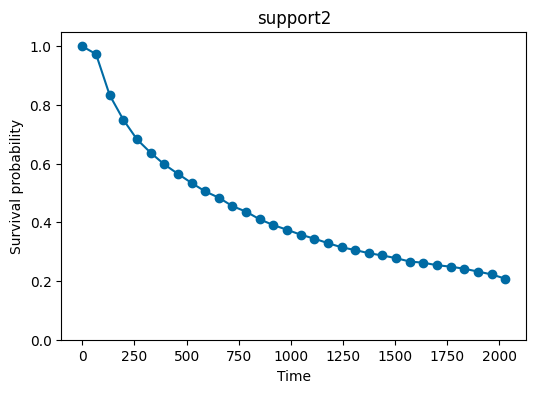

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

x = list_t_dist[1].boundaries
y = 1.0 - list_t_dist[1].cdf(x)

plt.style.use("tableau-colorblind10")
plt.figure(figsize=(6, 4))
plt.title(dataset_name)
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.ylim(0.0, 1.05)
plt.plot(x[:-1], y[1,:-1], marker='o')  # Plot the 1st survival function
plt.show()